# Aim of this notebook

* To construct the singular curve of universal type to finalize the solution of the optimal control problem

# Preamble

In [1]:
from sympy import *
init_printing(use_latex='mathjax')

# Plotting
%matplotlib inline
## Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
## Import modules for plotting and data analysis
import matplotlib.pyplot as plt
from matplotlib import gridspec,rc,colors
import matplotlib.ticker as plticker
## Parameters for seaborn plots
import seaborn as sns
sns.set(style='white',font_scale=1.25,
        rc={"xtick.major.size": 6, "ytick.major.size": 6,
            'text.usetex': False, 'font.family': 'serif', 'font.serif': ['Times']})

import pandas as pd
pd.set_option('mode.chained_assignment',None)

import numpy as np
from numpy.linalg import norm
from scipy.optimize import fsolve, root
from scipy.integrate import ode
backend = 'dopri5'
import warnings

# For I/O
import csv


# Timer
import time

from copy import deepcopy

from itertools import cycle
palette_size = 10;
clrs = sns.color_palette("Reds",palette_size)
iclrs = cycle(clrs) # iterated colors

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Parameter values

* Birth rate and const of downregulation are defined below in order to fit some experim. data

In [2]:
d = .13 # death rate
α = .3 # low equilibrium point at expression of the main pathway (high equilibrium is at one)
θ = .45 # threshold value for the expression of the main pathway
κ = 40 # robustness parameter

* Symbolic variables - the list insludes μ & μbar, because they will be varied later

In [3]:
σ, φ0, φ, x, μ, μbar = symbols('sigma, phi0, phi, x, mu, mubar')

* Main functions

In [4]:
A = 1-σ*(1-θ)
Eminus = (α*A-θ)**2/2
ΔE = A*(1-α)*((1+α)*A/2-θ)
ΔEf = lambdify(σ,ΔE)

* Birth rate and cost of downregulation

In [5]:
b = (0.1*(exp(κ*(ΔEf(1)))+1)-0.14*(exp(κ*ΔEf(0))+1))/(exp(κ*ΔEf(1))-exp(κ*ΔEf(0))) # birth rate
χ = 1-(0.14*(exp(κ*ΔEf(0))+1)-b*exp(κ*ΔEf(0)))/b
b, χ

(0.140168330860362, 0.325961223954473)

In [6]:
nonadjusted_cost = 0.1
c = (nonadjusted_cost*(b-d)+(1-nonadjusted_cost)*χ/(exp(κ*ΔEf(0))+1))/b # cost of resistance # cost of resistance
c

0.0149652955516160

* Hamiltonian *H* and a part of it ρ that includes the control variable σ

In [7]:
h = b*(χ/(exp(κ*ΔE)+1)*(1-x)+c*x)
H = -φ0 + φ*(b*(χ/(exp(κ*ΔE)+1)-c)*x*(1-x)+μ*(1-x)/(exp(κ*ΔE)+1)-μbar*exp(-κ*Eminus)*x) + h
ρ = (φ*(b*χ*x+μ)+b*χ)/(exp(κ*ΔE)+1)*(1-x)-φ*μbar*exp(-κ*Eminus)*x
H, ρ

⎛  ⎛                                                                        2 
⎜  ⎜                μ⋅(-x + 1)                         -20⋅(-0.165⋅σ - 0.15)  
⎜φ⋅⎜────────────────────────────────────────── - μ̅⋅x⋅ℯ                       
⎜  ⎜ 40⋅(-0.385⋅σ + 0.7)⋅(-0.3575⋅σ + 0.2)                                    
⎝  ⎝ℯ                                      + 1                                

                                                                              
    ⎛                                   0.045689440686899             ⎞       
+ x⋅⎜-0.00209766049830201 + ──────────────────────────────────────────⎟⋅(-x + 
    ⎜                        40⋅(-0.385⋅σ + 0.7)⋅(-0.3575⋅σ + 0.2)    ⎟       
    ⎝                       ℯ                                      + 1⎠       

  ⎞                                                                           
  ⎟                                        0.045689440686899⋅(-x + 1)         
1)⎟ - φ₀ + 0.00209766049830201⋅x + ───────────────

* Same but for no treatment (σ = 0)

In [8]:
h0 = h.subs(σ,0)
H0 = H.subs(σ,0)
ρ0 = ρ.subs(σ,0)
H0, ρ0

(φ⋅(0.00368423989943599⋅μ⋅(-x + 1) - 0.637628151621773⋅μ̅⋅x - 0.00192932963794
043⋅x⋅(-x + 1)) - φ₀ + 0.00192932963794043⋅x + 0.000168330860361587, -0.637628
151621773⋅μ̅⋅φ⋅x + 0.00368423989943599⋅(-x + 1)⋅(φ⋅(μ + 0.045689440686899⋅x) +
 0.045689440686899))

* Machinery: definition of the Poisson brackets

In [9]:
PoissonBrackets = lambda H1, H2: diff(H1,x)*diff(H2,φ)-diff(H1,φ)*diff(H2,x)

* Necessary functions and defining the right hand side of dynamical equations

In [10]:
ρf = lambdify((x,φ,σ,μ,μbar),ρ)
ρ0f = lambdify((x,φ,μ,μbar),ρ0)
dxdτ = lambdify((x,φ,σ,μ,μbar),-diff(H,φ))
dφdτ = lambdify((x,φ,σ,μ,μbar),diff(H,x))
dVdτ = lambdify((x,σ),h)
dρdσ = lambdify((σ,x,φ,μ,μbar),diff(ρ,σ))
dδρdτ = lambdify((x,φ,σ,μ,μbar),-PoissonBrackets(ρ0-ρ,H))
def ode_rhs(t,state,μ,μbar):
    x, φ, V, δρ = state
    σs = [0,1]
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    if ρf(x,φ,σstar,μ,μbar) < ρ0f(x,φ,μ,μbar):
        sgm = 0
    else:
        sgm = σstar
    return [dxdτ(x,φ,sgm,μ,μbar),dφdτ(x,φ,sgm,μ,μbar),dVdτ(x,sgm),dδρdτ(x,φ,σstar,μ,μbar)]
def σstarf(x,φ,μ,μbar):
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    if ρf(x,φ,σstar,μ,μbar) < ρ0f(x,φ,μ,μbar):
        sgm = 0
    else:
        sgm = σstar
    return sgm

In [11]:
def get_primary_field(name, experiment,μ,μbar):
    solutions = {}
    solver = ode(ode_rhs).set_integrator(backend)
    τ0 = experiment['τ0']
    tms = np.linspace(τ0,experiment['T_end'],1e3+1)
    for x0 in experiment['x0']:
        δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
        solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
        sol = []; k = 0;
        while (solver.t < experiment['T_end']) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
            solver.integrate(tms[k])
            sol.append([solver.t]+list(solver.y))
            k += 1
        solutions[x0] = {'solution': sol}
    for x0, entry in solutions.items():
        entry['τ'] = [entry['solution'][j][0] for j in range(len(entry['solution']))]
        entry['x'] = [entry['solution'][j][1] for j in range(len(entry['solution']))]
        entry['φ'] = [entry['solution'][j][2] for j in range(len(entry['solution']))]
        entry['V'] = [entry['solution'][j][3] for j in range(len(entry['solution']))]
        entry['δρ'] = [entry['solution'][j][4] for j in range(len(entry['solution']))]
    return solutions
def get_δρ_value(tme,x0,μ,μbar):
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    while (solver.t < tme) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tme)
        sol = [solver.t]+list(solver.y)
    return solver.y[3]
def get_δρ_ending(params,μ,μbar):
    tme, x0 = params
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    _k = 0; sol = []
    while (_k<len(tms)):# and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append(solver.y)
        _k += 1
    #print(sol)
    return(sol[0][3],(sol[1][3]-sol[0][3])/δτ)
def get_state(tme,x0,μ,μbar):
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    _k = 0; sol = []
    while (solver.t < tms[-1]) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append(solver.y)
        _k += 1
    return(list(sol[0])+[(sol[1][3]-sol[0][3])/δτ])

# Machinery for the universal line

* To find the universal singular curve we need to define two parameters

In [12]:
γ0 = PoissonBrackets(PoissonBrackets(H,H0),H)
γ1 = PoissonBrackets(PoissonBrackets(H0,H),H0)

* The dynamics

In [13]:
dxdτSingExpr = -(γ0*diff(H0,φ)+γ1*diff(H,φ))/(γ0+γ1)
dφdτSingExpr = (γ0*diff(H0,x)+γ1*diff(H,x))/(γ0+γ1)
dVdτSingExpr = (γ0*h0+γ1*h)/(γ0+γ1)
σSingExpr = γ1*σ/(γ0+γ1)

* Machinery for Python: lambdify the functions above

In [14]:
dxdτSing = lambdify((x,φ,σ,μ,μbar),dxdτSingExpr)
dφdτSing = lambdify((x,φ,σ,μ,μbar),dφdτSingExpr)
dVdτSing = lambdify((x,φ,σ,μ,μbar),dVdτSingExpr)
σSing = lambdify((x,φ,σ,μ,μbar),σSingExpr)

In [15]:
def ode_rhs_Sing(t,state,μ,μbar):
    x, φ, V = state
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    return [dxdτSing(x,φ,σstar,μ,μbar),dφdτSing(x,φ,σstar,μ,μbar),dVdτSing(x,φ,σstar,μ,μbar)]
def get_universal_curve(end_point,tmax,Nsteps,μ,μbar):
    tms =  np.linspace(end_point[0],tmax,Nsteps);
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    _k = 0; sol = []
    while (solver.t < tms[-1]):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_σ_universal(tme,end_point,μ,μbar):
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    _k = 0; sol = []
    while (solver.t < tme+δτ):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    x, φ = sol[0][:2]
    sgm = fsolve(lambda σ: dxdτ(x,φ,σ,μ,μbar)-(sol[1][0]-sol[0][0])/δτ,θ/2)[0]
    return sgm
def get_state_universal(tme,end_point,μ,μbar):
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    solver.integrate(tme)
    return [solver.t]+list(solver.y)

In [16]:
def ode_rhs_with_σstar(t,state,μ,μbar):
    x, φ, V = state
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σ = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σ = 1.;
    return [dxdτ(x,φ,σ,μ,μbar),dφdτ(x,φ,σ,μ,μbar),dVdτ(x,σ)]
def ode_rhs_with_given_σ(t,state,σ,μ,μbar):
    x, φ, V = state
    return [dxdτ(x,φ,σ,μ,μbar),dφdτ(x,φ,σ,μ,μbar),dVdτ(x,σ)]
def get_trajectory_with_σstar(starting_point,tmax,Nsteps,μ,μbar):
    tms = np.linspace(starting_point[0],tmax,Nsteps)
    solver = ode(ode_rhs_with_σstar).set_integrator(backend)
    solver.set_initial_value(starting_point[1:],starting_point[0]).set_f_params(μ,μbar)
    sol = []; _k = 0;
    while solver.t < max(tms) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_trajectory_with_given_σ(starting_point,tmax,Nsteps,σ,μ,μbar):
    tms = np.linspace(starting_point[0],tmax,100)
    solver = ode(ode_rhs_with_given_σ).set_integrator(backend)
    solver.set_initial_value(starting_point[1:],starting_point[0]).set_f_params(σ,μ,μbar)
    sol = []; _k = 0;
    while solver.t < max(tms) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_state_with_σstar(tme,starting_point,μ,μbar):
    solver = ode(ode_rhs_with_σstar).set_integrator(backend)
    solver.set_initial_value(starting_point[1:4],starting_point[0]).set_f_params(μ,μbar)
    solver.integrate(tme)
    return [solver.t]+list(solver.y)
def get_finalizing_point_from_universal_curve(tme,tmx,end_point,μ,μbar):
    unv_point = get_state_universal(tme,end_point,μ,μbar)
    return get_state_with_σstar(tmx,unv_point,μ,μbar)[1]

# Field of optimal trajectories as the solution of the Bellman equation

* μ & μbar are varied by *T* and *T*bar ($\mu=1/T$ and $\bar\mu=1/\bar{T}$)

Parameters: μ = 0.06691, μbar = 0.03498
Ending point for the switching line: τ = 15.9 days, x = 69.3%
Checking the solution - should give zero values: 
(-8.590549742710653e-08, -8.84185532856548e-09)
* Constructing the primary field
* Constructing the switching curve
* Constructing the universal curve
* Finding the last characteristic
The last point on the universal line:
[161.86164523122653, 0.6932946733031988, -0.3217426077815867, 1.1080401111152556]
Final state:
[180.0, -8.112677196692175e-13, -0.5708368288545572, 1.5391671930299238]
Fold-change in tumor size: 1.34


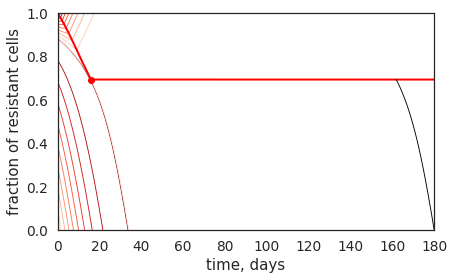

In [17]:
tmx = 180 #six months
end_switching_curve = {'t': 24., 'x': .9/.8} 
end_switching_curve = {'t': 25.797553399746018, 'x': 0.9572}
# for Τ, Τbar in zip([28]*5,[14,21,28,35,60]):
for Τ, Τbar in zip([14.94572081],[28.58943701]):
    μ = 1./Τ; μbar = 1./Τbar
    print("Parameters: μ = %.5f, μbar = %.5f"%(μ,μbar))
    end_switching_curve['t'], end_switching_curve['x'] = fsolve(get_δρ_ending,(end_switching_curve['t'],end_switching_curve['x']),args=(μ,μbar),xtol=1.0e-12)
    end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
    print("Ending point for the switching line: τ = %.1f days, x = %.1f%%" % (end_point[0], end_point[1]*100))
    print("Checking the solution - should give zero values: ")
    print(get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar))
    print("* Constructing the primary field")
    experiments = {
        'sol1': { 'T_end': tmx, 'τ0': 0., 'x0': list(np.linspace(0,end_switching_curve['x']-(1e-3),10))+
                 list(np.linspace(end_switching_curve['x']+(1e-6),1.,10)) } }
    primary_field = []
    for name, values in experiments.items():
        primary_field.append(get_primary_field(name,values,μ,μbar))
    print("* Constructing the switching curve")
    switching_curve = []
    x0s = np.linspace(end_switching_curve['x'],1,21); _y = end_switching_curve['t']
    
    for x0 in x0s:
        tme = fsolve(get_δρ_value,_y,args=(x0,μ,μbar))[0]
        if (tme>0):
            switching_curve = switching_curve+[[tme,get_state(tme,x0,μ,μbar)[0]]]
            _y = tme
    print("* Constructing the universal curve")
    universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
    print("* Finding the last characteristic")
    #time0 = time.time()
    tuniv = fsolve(get_finalizing_point_from_universal_curve,tmx-40.,args=(tmx,end_point,μ,μbar,))[0]
    #print("The proccess to find the last characteristic took %0.1f minutes" % ((time.time()-time0)/60.))
    univ_point = get_state_universal(tuniv,end_point,μ,μbar)
    print("The last point on the universal line:")
    print(univ_point)
    last_trajectory = get_trajectory_with_σstar(univ_point,tmx,50,μ,μbar)
    print("Final state:")
    final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
    print(final_state)
    print("Fold-change in tumor size: %.2f"%(exp((b-d)*tmx-final_state[-1])))
    # Plotting
    plt.rcParams['figure.figsize'] = (6.75, 4)
    _k = 0
    for solutions in primary_field:
        for x0, entry in solutions.items():
            plt.plot(entry['τ'], entry['x'], 'k-', linewidth=.9, color=clrs[_k%palette_size])
            _k += 1
    plt.plot([x[0] for x in switching_curve],[x[1] for x in switching_curve],linewidth=2,color="red")
    plt.plot([end_point[0]],[end_point[1]],marker='o',color="red")
    plt.plot([x[0] for x in universal_curve],[x[1] for x in universal_curve],linewidth=2,color="red")
    plt.plot([x[0] for x in last_trajectory],[x[1] for x in last_trajectory],linewidth=.9,color="black")
    plt.xlim([0,tmx]); plt.ylim([0,1]);
    plt.xlabel("time, days"); plt.ylabel("fraction of resistant cells")
    plt.show()
    print()

In [19]:
File = open("../figures/draft/sensitivity_mu-baseline_cost.csv", 'w')
File.write("T,Tbar,mu,mubar,sw_start_x,sw_end_t,sw_end_x,univ_point_t,univ_point_x,outcome,err_sw_t,err_sw_x\n")
writer = csv.writer(File,lineterminator='\n')

end_switching_curve0 = {'t': 45.48, 'x': .932}
end_switching_curve_prev_t = end_switching_curve['t']
tuniv = tmx-30.
Ts = np.arange(40,3,-1); #np.arange(30,28,-2)
Τbars = np.arange(40,3,-1) #need to change here if more
for Τ in Ts:
    μ = 1./Τ
    end_switching_curve = deepcopy(end_switching_curve0)
    for Τbar in Τbars:
        μbar = 1./Τbar
        print("* Parameters: T = %.1f, Tbar = %.1f (μ = %.5f, μbar = %.5f)"%(Τ,Τbar,μ,μbar))
        success = False; err = 1.
        while (not success)|(norm(err)>1e-6):
            end_switching_curve = {'t': 2*end_switching_curve['t']-end_switching_curve_prev_t-.001, 
                                   'x': end_switching_curve['x']-0.002} 
            sol = root(get_δρ_ending,(end_switching_curve['t'],end_switching_curve['x']),args=(μ,μbar))
            end_switching_curve_prev_t = end_switching_curve['t']
            end_switching_curve_prev_x = end_switching_curve['x']
            end_switching_curve['t'], end_switching_curve['x'] = sol.x 
            success = sol.success
            err = get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar)
            if (not success): 
                print("! Trying again...", sol.message)
            elif (norm(err)>1e-6):
                print("! Trying again... Convergence is not sufficient")       
        else:
            end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
            print("Ending point: t = %.2f, x = %.2f%%"%(end_switching_curve['t'],100*end_switching_curve['x'])," Checking the solution:",err)
            universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
            tuniv = root(get_finalizing_point_from_universal_curve,tuniv,args=(tmx,end_point,μ,μbar)).x
            err_tuniv = get_finalizing_point_from_universal_curve(tuniv,tmx,end_point,μ,μbar)
            univ_point = get_state_universal(tuniv,end_point,μ,μbar)
            print("tuniv = %.2f"%tuniv,"xuniv = %.2f%%"%(100*univ_point[1])," Checking the solution: ",err_tuniv)
            final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
            outcome = exp((b-d)*tmx-final_state[-1])
            print("Fold-change in tumor size: %.2f"%(outcome))
            output = [Τ,Τbar,μ,μbar,end_switching_curve['x'],end_point[0],end_point[1]]+list(univ_point[0:2])+[outcome]+list(err)+[err_tuniv]
            writer.writerow(output)
        if (Τbar==Τ):
            end_switching_curve0 = deepcopy(end_switching_curve) 

File.close()

* Parameters: T = 40.0, Tbar = 40.0 (μ = 0.02500, μbar = 0.02500)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 28.42, x = 85.59%  Checking the solution: (-2.073602803916543e-13, -2.1845585522551873e-14)
tuniv = 148.41 xuniv = 61.34%  Checking the solution:  -2.1716253795212026e-11
Fold-change in tumor size: 0.79
* Parameters: T = 40.0, Tbar = 39.0 (μ = 0.02500, μbar = 0.02564)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence i

Ending point: t = 24.86, x = 74.73%  Checking the solution: (1.85797476579333e-13, 4.076844517779224e-13)
tuniv = 153.63 xuniv = 49.98%  Checking the solution:  1.9999939204762285e-12
Fold-change in tumor size: 0.44
* Parameters: T = 40.0, Tbar = 17.0 (μ = 0.02500, μbar = 0.05882)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 24.64, x = 73.79%  Checking the solution: (-6.120741440776541e-08, -1.1468926426287917e-07)
tuniv = 153.98 xuniv = 49.15%  Checking the solution:  1.0797751581748116e-11
Fold-change in tumor size: 0.42
* Parameters: T = 40.0, Tbar = 16.0 (μ = 0.02500, μbar = 0.06250)
Ending point: t = 24.40, x = 72.77%  Checking the solution: (-1.6107129108994788e-07, -1.3170034076263957e-07)
tuniv = 154.30 xuniv = 48.31%  Checking the solution:  -1.1600581606430183e-11
Fold-change in tumor size: 0.40
* Parameters: T = 40.0, Tbar = 15.0 (μ = 0.02500, μbar = 0.06667)
Ending point: t = 2

Ending point: t = 26.63, x = 81.91%  Checking the solution: (-1.8413722211709954e-07, -2.4541560713342694e-07)
tuniv = 151.13 xuniv = 56.97%  Checking the solution:  4.098110739647609e-13
Fold-change in tumor size: 0.66
* Parameters: T = 39.0, Tbar = 28.0 (μ = 0.02564, μbar = 0.03571)
Ending point: t = 26.48, x = 81.45%  Checking the solution: (-1.1527664068273349e-07, -3.674811956134881e-07)
tuniv = 151.40 xuniv = 56.43%  Checking the solution:  -3.715264207393432e-12
Fold-change in tumor size: 0.65
* Parameters: T = 39.0, Tbar = 27.0 (μ = 0.02564, μbar = 0.03704)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 26.29, x = 80.97%  Check

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 22.15, x = 44.63%  Checking the solution: (-4.015342951565427e-07, 4.493635993093204e-07)
tuniv = 157.36 xuniv = 31.24%  Checking the solution:  -2.077893412888443e-12
Fold-change in tumor size: 0.08
* Parameters: T = 38.0, Tbar = 40.0 (μ = 0.02632, μbar = 0.02500)
Ending point: t = 27.75, x = 85.88%  Checking the solution: (-2.7313413871601975e-13, -3.225024434385906e-14)
tuniv = 149.08 xuniv = 62.02%  Checking the solution:  -8.029769904549511e-11
Fold-change in tumor size: 0.83
* Parameters: T = 38.0, Tbar = 39.0 (μ = 0.02632, μbar = 0.02564)
Ending point: t = 27.63, x = 85.60%  Checking the solution: (1.9346458249568663e-14, 1.9416637356988237e-15)
tuniv = 149.27 xuniv = 61.65%  Checking the solution:  1.0903646041615644e-10
Fold-change in tumor size: 0.81
* Parameters: T = 38.0, Tbar = 38.0 (μ = 0.02632, μbar = 0.02632)
Ending point: t = 27

tuniv = 154.67 xuniv = 49.75%  Checking the solution:  1.521395509573864e-11
Fold-change in tumor size: 0.44
* Parameters: T = 38.0, Tbar = 16.0 (μ = 0.02632, μbar = 0.06250)
! Trying again... Convergence is not sufficient
Ending point: t = 23.80, x = 73.25%  Checking the solution: (-1.4477029219709408e-07, -3.684594273468272e-07)
tuniv = 154.98 xuniv = 48.93%  Checking the solution:  3.734171305502798e-11
Fold-change in tumor size: 0.41
* Parameters: T = 38.0, Tbar = 15.0 (μ = 0.02632, μbar = 0.06667)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 23.54, x = 72.15%  Checking the solution: (-1.3659815137259567e-07, -2.3979020986780492e-08)
tuniv = 155.20 xuniv = 48.13%  Checking the solution:  -1.3556933353697787e-12
Fold-change in tumor size: 0.39
* Parameters: T = 38.0, Tbar = 14.0 (μ = 0.02632, μbar = 0.07143)
Ending point: t = 23.29, x = 70.95%  Checking the solution: (1.796062349410446e-13, 1.9218709000424664e-14)


Ending point: t = 25.82, x = 81.82%  Checking the solution: (-1.2286673428028654e-07, -2.4295781662900446e-07)
tuniv = 152.01 xuniv = 57.18%  Checking the solution:  2.8457236567192012e-12
Fold-change in tumor size: 0.67
* Parameters: T = 37.0, Tbar = 27.0 (μ = 0.02703, μbar = 0.03704)
Ending point: t = 25.66, x = 81.35%  Checking the solution: (-3.234638631755097e-08, -2.711207429621133e-07)
tuniv = 152.26 xuniv = 56.65%  Checking the solution:  2.075284388780574e-12
Fold-change in tumor size: 0.66
* Parameters: T = 37.0, Tbar = 26.0 (μ = 0.02703, μbar = 0.03846)
Ending point: t = 25.48, x = 80.84%  Checking the solution: (1.0072159829195737e-13, 1.5640732546042518e-14)
tuniv = 152.40 xuniv = 56.21%  Checking the solution:  1.326208587393296e-11
Fold-change in tumor size: 0.64
* Parameters: T = 37.0, Tbar = 25.0 (μ = 0.02703, μbar = 0.04000)
! Trying again... Convergence is not sufficient
Ending point: t = 25.32, x = 80.31%  Checking the solution: (-1.6114251468815936e-07, -3.02270626

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 20.87, x = 50.40%  Checking the solution: (6.806760816341177e-12, 8.65477459327099e-13)
tuniv = 158.70 xuniv = 34.34%  Checking the solution:  -3.849282004253496e-12
Fold-change in tumor size: 0.11
* Parameters: T = 37.0, Tbar = 4.0 (μ = 0.02703, μbar = 0.25000)
Ending point: t = 21.33, x = 45.42%  Checking the solution: (-1.7588676059530404e-11, -2.2848977416005003e-12)
tuniv = 158.32 xuniv = 31.77%  Checking the solution:  -1.0376977055415182e-12
Fold-change in tumor size: 0.08
* Parameters: T = 36.0, Tbar = 40.0 (μ = 0.02778, μbar = 0.02500)
Ending point: t = 27.05, x = 86.18%  Checking the solution: (-3.0837903099698895e-15, -1.8737544869006918e-16)
tuniv = 149.79 xuniv = 62.72%  Checking the solution:  2.3731044906938

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 23.16, x = 73.77%  Checking the solution: (-1.1845693518199367e-07, -1.6859880721628814e-07)
tuniv = 155.55 xuniv = 49.70%  Checking the solution:  1.0278354556358948e-11
Fold-change in tumor size: 0.44
* Parameters: T = 36.0, Tbar = 15.0 (μ = 0.02778, μbar = 0.06667)
! Trying again... Convergence is not sufficient
Ending point: t = 22.93, x = 72.68%  Checking the solution: (-1.531478598620514e-07, -5.754902488738119e-07)
tuniv = 155.98 xuniv = 48.70%  Checking the solution:  -3.928676828302002e-12
Fold-change in tumor size: 0.41
* Parameters: T = 36.0, Tbar = 14.0 (μ = 0.02778, μbar = 0.07143)
Ending point: t = 22.66, x = 71.50%  Checking the solution: (-2.012579456766221e-08, -3.572398578910903e-08)
tuniv = 15

! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 25.98, x = 84.56%  Checking the solution: (-1.4084585648563585e-07, -1.3790991018220329e-07)
tuniv = 151.37 xuniv = 60.72%  Checking the solution:  -2.3207130661617725e-12
Fold-change in tumor size: 0.80
* Parameters: T = 35.0, Tbar = 33.0 (μ = 0.02857, μbar = 0.03030)
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... Convergence is not sufficient
Ending point: t = 25.88, x = 84.21%  Checking the solution: (-2.27825988849613e-07, -4.914399874339574e-07)
tuniv = 151.72 xuniv = 60.14%  Checking the solution:  5.015557413834415e-12
Fold-change in tumor size: 0.78
* Parameters: T = 35.0, Tbar = 32.0 (μ = 0.02857, μbar = 0.03125)
Ending point: t = 25.72, x = 83.85%  Checking the solution: (-2.3149689886884616e-07, -1.822991958847

Ending point: t = 20.96, x = 63.56%  Checking the solution: (-2.6056644651862486e-12, -3.73592407809167e-14)
tuniv = 158.27 xuniv = 42.34%  Checking the solution:  -5.2533047356639884e-11
Fold-change in tumor size: 0.24
* Parameters: T = 35.0, Tbar = 8.0 (μ = 0.02857, μbar = 0.12500)
Ending point: t = 20.68, x = 61.19%  Checking the solution: (-2.3290298070418416e-08, -1.5713376562720347e-07)
tuniv = 158.68 xuniv = 40.78%  Checking the solution:  -8.82248094025151e-12
Fold-change in tumor size: 0.21
* Parameters: T = 35.0, Tbar = 7.0 (μ = 0.02857, μbar = 0.14286)
Ending point: t = 20.41, x = 58.43%  Checking the solution: (-1.4521157277261343e-07, 3.249223123758045e-07)
tuniv = 158.91 xuniv = 39.16%  Checking the solution:  5.832417881990182e-13
Fold-change in tumor size: 0.18
* Parameters: T = 35.0, Tbar = 6.0 (μ = 0.02857, μbar = 0.16667)
Ending point: t = 20.21, x = 55.16%  Checking the solution: (1.2326768498624983e-13, 6.2502606710188965e-12)
tuniv = 159.28 xuniv = 37.19%  Checkin

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 24.12, x = 80.39%  Checking the solution: (-2.0437855638166795e-07, -3.686443028754773e-08)
tuniv = 153.93 xuniv = 56.19%  Checking the solution:  9.742970319415178e-12
Fold-change in tumor size: 0.64
* Parameters: T = 34.0, Tbar = 23.0 (μ = 0.02941, μbar = 0.04348)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 23.94, x = 79.80%  Checking the solution: (-2.1598892989980956e-07, -5.2897954003815824e-08)
tuniv = 154.19 xuniv = 55.58%  Checking the solution:  2.2869206528497443e-13
Fold-change in tumor size: 0.62
* Parameters: T = 34.0, Tbar = 22.0 (μ = 0.02941, μbar = 0.04545)
Ending point: t = 23.79, x = 79.18%  Checking the solution: (-2.086864241262148e-0

Ending point: t = 25.39, x = 85.24%  Checking the solution: (-1.0472694600660871e-07, -3.7029873821596625e-07)
tuniv = 152.01 xuniv = 61.79%  Checking the solution:  3.792267888602652e-11
Fold-change in tumor size: 0.85
* Parameters: T = 33.0, Tbar = 34.0 (μ = 0.03030, μbar = 0.02941)
Ending point: t = 25.29, x = 84.92%  Checking the solution: (-1.5415843945257749e-07, -7.503129919825426e-07)
tuniv = 152.37 xuniv = 61.21%  Checking the solution:  -1.01045838363234e-11
Fold-change in tumor size: 0.84
* Parameters: T = 33.0, Tbar = 33.0 (μ = 0.03030, μbar = 0.03030)
Ending point: t = 25.11, x = 84.58%  Checking the solution: (-2.122545856174582e-07, -1.1858800074739106e-08)
tuniv = 152.25 xuniv = 61.12%  Checking the solution:  2.258976339319929e-11
Fold-change in tumor size: 0.82
* Parameters: T = 33.0, Tbar = 32.0 (μ = 0.03030, μbar = 0.03125)
! Trying again... Convergence is not sufficient
Ending point: t = 24.98, x = 84.23%  Checking the solution: (-2.2310123033417212e-07, -1.7067795

Ending point: t = 20.01, x = 61.94%  Checking the solution: (-1.2802432062253153e-12, -2.987189106618366e-13)
tuniv = 159.31 xuniv = 41.55%  Checking the solution:  -7.178632688287223e-14
Fold-change in tumor size: 0.23
* Parameters: T = 33.0, Tbar = 7.0 (μ = 0.03030, μbar = 0.14286)
Ending point: t = 19.74, x = 59.22%  Checking the solution: (-1.5201288426131996e-12, -3.842545760734873e-13)
tuniv = 159.66 xuniv = 39.84%  Checking the solution:  9.641246134783898e-12
Fold-change in tumor size: 0.19
* Parameters: T = 33.0, Tbar = 6.0 (μ = 0.03030, μbar = 0.16667)
Ending point: t = 19.51, x = 55.98%  Checking the solution: (-4.799811818549551e-12, -6.174709402252284e-13)
tuniv = 159.97 xuniv = 37.91%  Checking the solution:  -1.7855300571412158e-11
Fold-change in tumor size: 0.16
* Parameters: T = 33.0, Tbar = 5.0 (μ = 0.03030, μbar = 0.20000)
Ending point: t = 19.42, x = 52.05%  Checking the solution: (-6.335430272462031e-08, -9.005257155869467e-07)
tuniv = 160.36 xuniv = 35.56%  Checki

Ending point: t = 22.04, x = 75.85%  Checking the solution: (-1.576147185314812e-13, 4.934820997894632e-14)
tuniv = 156.54 xuniv = 52.16%  Checking the solution:  6.299967492129355e-11
Fold-change in tumor size: 0.51
* Parameters: T = 32.0, Tbar = 16.0 (μ = 0.03125, μbar = 0.06250)
! Trying again... Convergence is not sufficient
Ending point: t = 21.82, x = 74.89%  Checking the solution: (-6.059716619267966e-08, -1.322856193533686e-07)
tuniv = 156.88 xuniv = 51.27%  Checking the solution:  -1.2423811979189736e-12
Fold-change in tumor size: 0.48
* Parameters: T = 32.0, Tbar = 15.0 (μ = 0.03125, μbar = 0.06667)
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
Ending point: t = 21.60, x = 73.84%  Checking the solution: (-1.518948448308395e-07, -7.04860994921618e-07)
tuniv = 157.35 xuniv = 50.22%  Checking the solution: 

Ending point: t = 23.95, x = 83.88%  Checking the solution: (-1.9941030590843294e-07, -1.380248657880355e-08)
tuniv = 153.64 xuniv = 60.59%  Checking the solution:  5.890982146539159e-13
Fold-change in tumor size: 0.81
* Parameters: T = 31.0, Tbar = 29.0 (μ = 0.03226, μbar = 0.03448)
Ending point: t = 23.82, x = 83.48%  Checking the solution: (-1.7695505382460925e-07, -2.2356335088132603e-07)
tuniv = 153.94 xuniv = 60.03%  Checking the solution:  2.7664953661243885e-12
Fold-change in tumor size: 0.79
* Parameters: T = 31.0, Tbar = 28.0 (μ = 0.03226, μbar = 0.03571)
Ending point: t = 23.72, x = 83.06%  Checking the solution: (-1.4492419738246474e-07, -9.382581547985941e-07)
tuniv = 154.43 xuniv = 59.24%  Checking the solution:  -2.518957264996402e-13
Fold-change in tumor size: 0.77
* Parameters: T = 31.0, Tbar = 27.0 (μ = 0.03226, μbar = 0.03704)
Ending point: t = 23.51, x = 82.61%  Checking the solution: (-5.5315700826091183e-08, -2.4143835069470457e-08)
tuniv = 154.30 xuniv = 59.10%  

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not

! Trying again... Convergence is not sufficient
Ending point: t = 22.31, x = 80.19%  Checking the solution: (-2.0058698966741533e-07, 1.7395833275116786e-09)
tuniv = 155.88 xuniv = 56.65%  Checking the solution:  -6.094430515801719e-13
Fold-change in tumor size: 0.67
* Parameters: T = 30.0, Tbar = 21.0 (μ = 0.03333, μbar = 0.04762)
Ending point: t = 22.14, x = 79.55%  Checking the solution: (-1.3452905377951244e-07, -4.0460000180649714e-07)
tuniv = 156.27 xuniv = 55.85%  Checking the solution:  -2.593841808007369e-12
Fold-change in tumor size: 0.64
* Parameters: T = 30.0, Tbar = 20.0 (μ = 0.03333, μbar = 0.05000)
Ending point: t = 21.94, x = 78.86%  Checking the solution: (-1.2387436928540212e-12, -1.0486800319904084e-13)
tuniv = 156.41 xuniv = 55.30%  Checking the solution:  -2.2539886623818006e-11
Fold-change in tumor size: 0.62
* Parameters: T = 30.0, Tbar = 19.0 (μ = 0.03333, μbar = 0.05263)
Ending point: t = 21.74, x = 78.12%  Checking the solution: (-1.353406453235669e-07, -2.066

tuniv = 153.26 xuniv = 64.03%  Checking the solution:  -5.870781291661409e-14
Fold-change in tumor size: 0.95
* Parameters: T = 29.0, Tbar = 35.0 (μ = 0.03448, μbar = 0.02857)
! Trying again... Convergence is not sufficient
Ending point: t = 23.78, x = 86.03%  Checking the solution: (-1.0975479400685669e-07, -4.904277089466056e-09)
tuniv = 153.44 xuniv = 63.64%  Checking the solution:  -1.2357927181572137e-12
Fold-change in tumor size: 0.94
* Parameters: T = 29.0, Tbar = 34.0 (μ = 0.03448, μbar = 0.02941)
Ending point: t = 23.67, x = 85.72%  Checking the solution: (-1.8168162340169959e-07, -1.014686310853242e-07)
tuniv = 153.67 xuniv = 63.19%  Checking the solution:  -8.176181953700734e-12
Fold-change in tumor size: 0.92
* Parameters: T = 29.0, Tbar = 33.0 (μ = 0.03448, μbar = 0.03030)
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 23.55, x = 8

! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 18.90, x = 65.86%  Checking the solution: (-1.0925405239734626e-07, -1.451095340621652e-07)
tuniv = 160.37 xuniv = 44.73%  Checking the solution:  -1.749784692139933e-11
Fold-change in tumor size: 0.29
* Parameters: T = 29.0, Tbar = 8.0 (μ = 0.03448, μbar = 0.12500)
Ending point: t = 18.60, x = 63.59%  Checking the solution: (1.3838073007897862e-12, 2.0221540790013313e-13)
tuniv = 160.71 xuniv = 43.20%  Checking the solution:  2.0599251471242752e-12
Fold-change in tumor size: 0.26
* Parameters: T = 29.0, Tbar = 7.0 (μ = 0.03448, μbar = 0.14286)
Ending point: t = 18.32, x = 60.94%  Checking the solution: (-8.491379969849047e-08, -6.211118576649793e-07)
tuniv = 161.22 xuniv = 41.35%  Checking the solution:  -3.45690143177535e-12
Fold-change in tumor size: 0.22
* Parameters: T = 29.0, Tbar = 6.0 (μ = 

Fold-change in tumor size: 0.73
* Parameters: T = 28.0, Tbar = 22.0 (μ = 0.03571, μbar = 0.04545)
Ending point: t = 21.53, x = 80.74%  Checking the solution: (-1.940424193071242e-07, -8.711068941646884e-08)
tuniv = 156.69 xuniv = 57.54%  Checking the solution:  -2.14363249373406e-13
Fold-change in tumor size: 0.71
* Parameters: T = 28.0, Tbar = 21.0 (μ = 0.03571, μbar = 0.04762)
Ending point: t = 21.37, x = 80.12%  Checking the solution: (-1.5332312425458137e-07, -4.921182755362509e-07)
tuniv = 157.08 xuniv = 56.74%  Checking the solution:  2.7512436773236004e-12
Fold-change in tumor size: 0.68
* Parameters: T = 28.0, Tbar = 20.0 (μ = 0.03571, μbar = 0.05000)
Ending point: t = 21.17, x = 79.44%  Checking the solution: (-1.06313465318964e-12, -1.4825114236222878e-13)
tuniv = 157.18 xuniv = 56.23%  Checking the solution:  1.5757534166382925e-12
Fold-change in tumor size: 0.66
* Parameters: T = 28.0, Tbar = 19.0 (μ = 0.03571, μbar = 0.05263)
Ending point: t = 21.00, x = 78.72%  Checking t

Ending point: t = 22.97, x = 86.46%  Checking the solution: (-1.6864451604493984e-07, -6.183939499598999e-07)
tuniv = 154.58 xuniv = 64.27%  Checking the solution:  2.2182228276435012e-11
Fold-change in tumor size: 0.99
* Parameters: T = 27.0, Tbar = 34.0 (μ = 0.03704, μbar = 0.02941)
Ending point: t = 22.86, x = 86.16%  Checking the solution: (-1.85834353270818e-07, -6.59859931732032e-07)
tuniv = 154.78 xuniv = 63.85%  Checking the solution:  1.3045502178510304e-10
Fold-change in tumor size: 0.97
* Parameters: T = 27.0, Tbar = 33.0 (μ = 0.03704, μbar = 0.03030)
! Trying again... Convergence is not sufficient
Ending point: t = 22.70, x = 85.85%  Checking the solution: (-1.8858004267901994e-07, 1.920101930439331e-09)
tuniv = 154.68 xuniv = 63.75%  Checking the solution:  5.571043626417804e-12
Fold-change in tumor size: 0.96
* Parameters: T = 27.0, Tbar = 32.0 (μ = 0.03704, μbar = 0.03125)
! Trying again... Convergence is not sufficient
Ending point: t = 22.60, x = 85.52%  Checking the s

Fold-change in tumor size: 0.35
* Parameters: T = 27.0, Tbar = 9.0 (μ = 0.03704, μbar = 0.11111)
Ending point: t = 18.16, x = 66.74%  Checking the solution: (-1.4260245473584116e-07, -8.881732316233233e-08)
tuniv = 161.10 xuniv = 45.67%  Checking the solution:  -6.651901252041625e-13
Fold-change in tumor size: 0.32
* Parameters: T = 27.0, Tbar = 8.0 (μ = 0.03704, μbar = 0.12500)
Ending point: t = 17.86, x = 64.51%  Checking the solution: (6.121802826131354e-14, 2.5771878776468926e-14)
tuniv = 161.46 xuniv = 44.12%  Checking the solution:  -1.6306400674181987e-15
Fold-change in tumor size: 0.28
* Parameters: T = 27.0, Tbar = 7.0 (μ = 0.03704, μbar = 0.14286)
Ending point: t = 17.55, x = 61.90%  Checking the solution: (-1.155291853017812e-07, 8.74411598502357e-07)
tuniv = 161.66 xuniv = 42.53%  Checking the solution:  -2.6578877987404326e-12
Fold-change in tumor size: 0.24
* Parameters: T = 27.0, Tbar = 6.0 (μ = 0.03704, μbar = 0.16667)
! Trying again... The iteration is not making good 

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 20.88, x = 81.91%  Checking the solution: (-1.8302029968682877e-07, -8.005002393848197e-08)
tuniv = 157.27 xuniv = 59.15%  Checking the solution:  1.7268964036531997e-12
Fold-change in tumor size: 0.78
* Parameters: T = 26.0, Tbar = 22.0 (μ = 0.03846, μbar = 0.04545)
Ending point: t = 20.72, x = 81.34%  Checking the solution: (-1.880276688278694e-07, -1.7769884612811062e-07)
tuniv = 157.55 xuniv = 58.49%  Checking the solution:  2.3906571167131574e-13
Fold-change in tumor size: 0.75
* Parameters: T = 26.0, Tbar = 21.0 (μ = 0.03846, μbar = 0.04762)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 20.54, x = 80.73%  Checking the solution: (-1.5220686302612357e-07, 8.496216916993463e-10)
tuniv = 157.74 xuniv = 57.90%  Checking the solution:  1.4

Ending point: t = 21.96, x = 86.63%  Checking the solution: (-1.8581972286331054e-07, -7.069758932541021e-07)
tuniv = 155.70 xuniv = 64.82%  Checking the solution:  2.0837498393433407e-12
Fold-change in tumor size: 1.03
* Parameters: T = 25.0, Tbar = 33.0 (μ = 0.04000, μbar = 0.03030)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 21.85, x = 86.33%  Checking the solution: (-1.9295956476893636e-07, -7.677559282304606e-07)
tuniv = 155.91 xuniv = 64.38%  Checking the solution:  -1.2826587014735935e-11
Fold-change in tumor size: 1.01
* Parameters: T = 25.0, Tbar = 32.0 (μ = 0.04000, μbar = 0.03125)
Ending point: t = 21.70, x = 86.01%  Checking the solution: (-1.7883152790880018e-07, -2.306272589073141e-07)
tuniv = 155.87 xuniv = 64.21%  Checking the solution:  5.9674487573602164e-15
Fold-change in tumor size: 0.99
* Parameters: T = 25.0, Tbar = 31.0 (μ = 0.04000, μbar = 0.03226)
Ending point: t 

! Trying again... Convergence is not sufficient
Ending point: t = 17.38, x = 67.69%  Checking the solution: (-1.2259037009770939e-07, -2.3068537330842964e-07)
tuniv = 161.90 xuniv = 46.65%  Checking the solution:  -1.1141781941503837e-12
Fold-change in tumor size: 0.34
* Parameters: T = 25.0, Tbar = 8.0 (μ = 0.04000, μbar = 0.12500)
Ending point: t = 17.08, x = 65.50%  Checking the solution: (2.7214041025021285e-13, 3.976189652805368e-14)
tuniv = 162.24 xuniv = 45.12%  Checking the solution:  -3.400058012914542e-16
Fold-change in tumor size: 0.30
* Parameters: T = 25.0, Tbar = 7.0 (μ = 0.04000, μbar = 0.14286)
Ending point: t = 16.78, x = 62.93%  Checking the solution: (-1.0136997530624818e-07, -5.9449241660592544e-08)
tuniv = 162.63 xuniv = 43.34%  Checking the solution:  9.681144774731365e-14
Fold-change in tumor size: 0.26
* Parameters: T = 25.0, Tbar = 6.0 (μ = 0.04000, μbar = 0.16667)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement fr

tuniv = 159.22 xuniv = 57.44%  Checking the solution:  -1.1697323665238457e-11
Fold-change in tumor size: 0.72
* Parameters: T = 24.0, Tbar = 18.0 (μ = 0.04167, μbar = 0.05556)
Ending point: t = 19.13, x = 79.32%  Checking the solution: (-5.056378391346279e-13, 2.7569085672114954e-15)
tuniv = 159.38 xuniv = 56.81%  Checking the solution:  1.8371415499984778e-13
Fold-change in tumor size: 0.69
* Parameters: T = 24.0, Tbar = 17.0 (μ = 0.04167, μbar = 0.05882)
! Trying again... Convergence is not sufficient
Ending point: t = 18.94, x = 78.51%  Checking the solution: (-3.285515013189264e-12, 1.0861782132648399e-13)
tuniv = 159.65 xuniv = 56.01%  Checking the solution:  -3.213292132375756e-11
Fold-change in tumor size: 0.66
* Parameters: T = 24.0, Tbar = 16.0 (μ = 0.04167, μbar = 0.06250)
Ending point: t = 18.74, x = 77.64%  Checking the solution: (-4.753737947836581e-09, -3.817337347026876e-07)
tuniv = 160.04 xuniv = 55.04%  Checking the solution:  1.362879253896665e-11
Fold-change in tumo

Ending point: t = 20.26, x = 85.13%  Checking the solution: (-3.0737956908005654e-08, -1.5571682906070177e-07)
tuniv = 157.56 xuniv = 63.48%  Checking the solution:  -5.717537554517094e-12
Fold-change in tumor size: 0.97
* Parameters: T = 23.0, Tbar = 27.0 (μ = 0.04348, μbar = 0.03704)
Ending point: t = 20.12, x = 84.73%  Checking the solution: (3.1412764032209654e-14, 4.4227941035097434e-15)
tuniv = 157.71 xuniv = 63.04%  Checking the solution:  -4.7778614398197305e-11
Fold-change in tumor size: 0.95
* Parameters: T = 23.0, Tbar = 26.0 (μ = 0.04348, μbar = 0.03846)
Ending point: t = 19.99, x = 84.31%  Checking the solution: (7.273632960211774e-14, 3.7521351065850893e-14)
tuniv = 157.92 xuniv = 62.52%  Checking the solution:  3.273327442432361e-11
Fold-change in tumor size: 0.93
* Parameters: T = 23.0, Tbar = 25.0 (μ = 0.04348, μbar = 0.04000)
Ending point: t = 19.85, x = 83.85%  Checking the solution: (-1.0210641176801209e-07, -1.496914740870426e-08)
tuniv = 158.14 xuniv = 61.97%  Che

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 15.67, x = 61.04%  Checking the solution: (-1.1974676910113788e-07, -8.233237142021542e-07)
tuniv = 163.98 xuniv = 42.26%  Checking the solution:  1.908168067998872e-12
Fold-change in tumor size: 0.23
* Parameters: T = 23.0, Tbar = 5.0 (μ = 0.04348, μbar = 0.20000)
Ending point: t = 15.40, x = 57.35%  Checking the solution: (-1.0226075816268286e-07, -5.826003003430907e-07)
tuniv = 164.28 xuniv = 39.98%  Checking the solution:  6.295755583529683e-12
Fold-change in tumor size: 0.18
* Parameters: T = 23.0, Tbar = 4.0 (μ = 0.04348, μbar = 0.25000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying 

Fold-change in tumor size: 0.98
* Parameters: T = 22.0, Tbar = 26.0 (μ = 0.04545, μbar = 0.03846)
Ending point: t = 19.52, x = 84.63%  Checking the solution: (-2.417177166367091e-08, -1.7971150328252198e-07)
tuniv = 158.46 xuniv = 63.02%  Checking the solution:  -1.1811357447655269e-11
Fold-change in tumor size: 0.96
* Parameters: T = 22.0, Tbar = 25.0 (μ = 0.04545, μbar = 0.04000)
Ending point: t = 19.38, x = 84.18%  Checking the solution: (-1.1783411621260494e-07, -1.100016886415673e-07)
tuniv = 158.65 xuniv = 62.51%  Checking the solution:  3.983910423777104e-12
Fold-change in tumor size: 0.94
* Parameters: T = 22.0, Tbar = 24.0 (μ = 0.04545, μbar = 0.04167)
Ending point: t = 19.25, x = 83.71%  Checking the solution: (-1.530761275188787e-07, -4.003159738570809e-07)
tuniv = 158.96 xuniv = 61.82%  Checking the solution:  3.01558777948685e-12
Fold-change in tumor size: 0.91
* Parameters: T = 22.0, Tbar = 23.0 (μ = 0.04545, μbar = 0.04348)
! Trying again... The iteration is not making g

Ending point: t = 20.51, x = 89.14%  Checking the solution: (-1.1076193012245326e-07, 3.261211842805025e-09)
tuniv = 156.41 xuniv = 69.58%  Checking the solution:  1.0064171718227044e-13
Fold-change in tumor size: 1.26
* Parameters: T = 21.0, Tbar = 39.0 (μ = 0.04762, μbar = 0.02564)
Ending point: t = 20.43, x = 88.93%  Checking the solution: (-1.2312212299089273e-07, -1.2489729770858213e-07)
tuniv = 156.63 xuniv = 69.17%  Checking the solution:  -4.020395127923848e-12
Fold-change in tumor size: 1.25
* Parameters: T = 21.0, Tbar = 38.0 (μ = 0.04762, μbar = 0.02632)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 20.33, x = 88.70%  Checking the solution: (-1.3395631242597523e-07, -4.879351556806322e-08)
tuniv = 156.75 xuniv = 68.86%  Checking the solution:  -1.875943844709127e-12
Fold-change in tumor size: 1.23
* Parameters: T = 21.0, Tbar = 37.0 (μ = 0.04762, μbar = 0.02703)
Ending point: t =

Ending point: t = 17.18, x = 77.98%  Checking the solution: (-1.2053442480660056e-07, 3.529417202256574e-07)
tuniv = 161.47 xuniv = 56.17%  Checking the solution:  6.759870441186422e-14
Fold-change in tumor size: 0.66
* Parameters: T = 21.0, Tbar = 14.0 (μ = 0.04762, μbar = 0.07143)
Ending point: t = 16.98, x = 76.97%  Checking the solution: (-7.693927579593644e-08, -1.3815284452543174e-07)
tuniv = 161.89 xuniv = 55.05%  Checking the solution:  -4.27424762250439e-12
Fold-change in tumor size: 0.62
* Parameters: T = 21.0, Tbar = 13.0 (μ = 0.04762, μbar = 0.07692)
! Trying again... Convergence is not sufficient
Ending point: t = 16.75, x = 75.86%  Checking the solution: (3.036096490130406e-13, 4.683282663954198e-14)
tuniv = 162.16 xuniv = 54.06%  Checking the solution:  2.60753640901612e-11
Fold-change in tumor size: 0.58
* Parameters: T = 21.0, Tbar = 12.0 (μ = 0.04762, μbar = 0.08333)
Ending point: t = 16.51, x = 74.61%  Checking the solution: (-4.286030147719341e-08, 1.040360316235883

Ending point: t = 18.87, x = 86.45%  Checking the solution: (-5.93117491020723e-14, -9.498862224206008e-15)
tuniv = 158.82 xuniv = 65.84%  Checking the solution:  -6.1131442789796875e-12
Fold-change in tumor size: 1.10
* Parameters: T = 20.0, Tbar = 28.0 (μ = 0.05000, μbar = 0.03571)
! Trying again... Convergence is not sufficient
Ending point: t = 18.76, x = 86.09%  Checking the solution: (-1.0994558213205325e-13, -1.2072253976959232e-14)
tuniv = 159.01 xuniv = 65.36%  Checking the solution:  1.085501480369011e-12
Fold-change in tumor size: 1.08
* Parameters: T = 20.0, Tbar = 27.0 (μ = 0.05000, μbar = 0.03704)
Ending point: t = 18.65, x = 85.71%  Checking the solution: (-1.3283462754596542e-08, -3.439180707816597e-07)
tuniv = 159.34 xuniv = 64.70%  Checking the solution:  -3.094574076156764e-12
Fold-change in tumor size: 1.06
* Parameters: T = 20.0, Tbar = 26.0 (μ = 0.05000, μbar = 0.03846)
! Trying again... Convergence is not sufficient
Ending point: t = 18.51, x = 85.30%  Checking t

Ending point: t = 13.84, x = 54.86%  Checking the solution: (-1.15184076429159e-07, 6.774199120513928e-07)
tuniv = 165.69 xuniv = 39.11%  Checking the solution:  -2.856603842360528e-13
Fold-change in tumor size: 0.16
* Parameters: T = 19.0, Tbar = 40.0 (μ = 0.05263, μbar = 0.02500)
Ending point: t = 19.41, x = 89.68%  Checking the solution: (-1.2203683785937195e-07, -2.972637485024158e-07)
tuniv = 157.69 xuniv = 70.63%  Checking the solution:  -7.780442956573097e-13
Fold-change in tumor size: 1.35
* Parameters: T = 19.0, Tbar = 39.0 (μ = 0.05263, μbar = 0.02564)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 19.29, x = 89.47%  Checking the solution: (-1.26456502269693e-07, 2.1106281482294542e-07)
tuniv = 157.59 xuniv = 70.59%  Checking the solution:  -1.9696744235631058e-13
Fold-change in tumor size: 1.33
* Parameters: T = 19.0, Tbar = 38.0 (μ = 0.05263, μbar = 0.02632)
Ending point: t = 19.24, x = 89.25%  Checking the 

Ending point: t = 15.58, x = 75.69%  Checking the solution: (1.3786460291925024e-13, 2.2987729895567063e-14)
tuniv = 163.41 xuniv = 54.29%  Checking the solution:  -3.4833247397614286e-15
Fold-change in tumor size: 0.59
* Parameters: T = 19.0, Tbar = 11.0 (μ = 0.05263, μbar = 0.09091)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence 

Ending point: t = 17.67, x = 86.79%  Checking the solution: (-4.244996246115521e-08, 6.322986469456575e-09)
tuniv = 160.11 xuniv = 66.71%  Checking the solution:  -8.236050730303646e-13
Fold-change in tumor size: 1.16
* Parameters: T = 18.0, Tbar = 27.0 (μ = 0.05556, μbar = 0.03704)
Ending point: t = 17.55, x = 86.43%  Checking the solution: (-8.943938474155419e-08, -3.498299011719464e-09)
tuniv = 160.30 xuniv = 66.22%  Checking the solution:  5.0088877490139794e-11
Fold-change in tumor size: 1.14
* Parameters: T = 18.0, Tbar = 26.0 (μ = 0.05556, μbar = 0.03846)
Ending point: t = 17.44, x = 86.05%  Checking the solution: (-1.1485044553011364e-07, -1.198266527603635e-07)
tuniv = 160.53 xuniv = 65.65%  Checking the solution:  3.9890972469702746e-12
Fold-change in tumor size: 1.11
* Parameters: T = 18.0, Tbar = 25.0 (μ = 0.05556, μbar = 0.04000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 17

Ending point: t = 18.19, x = 90.26%  Checking the solution: (-1.1176816319026388e-07, -2.4520200924693105e-09)
tuniv = 158.77 xuniv = 72.15%  Checking the solution:  -2.353950367961488e-13
Fold-change in tumor size: 1.45
* Parameters: T = 17.0, Tbar = 39.0 (μ = 0.05882, μbar = 0.02564)
Ending point: t = 18.08, x = 90.07%  Checking the solution: (-1.1083936287421108e-07, 5.829621250248891e-07)
tuniv = 158.62 xuniv = 72.17%  Checking the solution:  -3.540223669773468e-14
Fold-change in tumor size: 1.43
* Parameters: T = 17.0, Tbar = 38.0 (μ = 0.05882, μbar = 0.02632)
Ending point: t = 18.03, x = 89.86%  Checking the solution: (-1.319729885217685e-07, 5.649687258873522e-08)
tuniv = 159.03 xuniv = 71.52%  Checking the solution:  3.026606743006255e-13
Fold-change in tumor size: 1.42
* Parameters: T = 17.0, Tbar = 37.0 (μ = 0.05882, μbar = 0.02703)
Ending point: t = 17.99, x = 89.65%  Checking the solution: (-1.1289075039411725e-07, -7.173457880785805e-07)
tuniv = 159.54 xuniv = 70.73%  Chec

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 14.37, x = 75.57%  Checking the solution: (-8.550203096852015e-08, -3.866897985097373e-07)
tuniv = 164.79 xuniv = 54.47%  Checking the solution:  -1.7277845820728999e-15
Fold-change in tumor size: 0.60
* Parameters: T = 17.0, Tbar = 10.0 (μ = 0.05882, μbar = 0.10000)
Ending point: t = 14.11, x = 74.09%  Checking the solution: (-8.719257960051551e-08, 5.103365658917508e-07)
tuniv = 164.94 xuniv = 53.41%  Checking the solution:  -8.874845303097345e-14
Fold-change in tumor size: 0.55
* Parameters: T = 17.0, Tbar = 9.0 (μ = 0.05882, μbar = 0.11111)
Ending point: t = 13.85, x = 72.39%  Checking

! Trying again... Convergence is not sufficient
Ending point: t = 16.16, x = 86.47%  Checking the solution: (2.195575213743148e-14, 3.9815766261549414e-16)
tuniv = 161.85 xuniv = 66.68%  Checking the solution:  1.181693631835401e-13
Fold-change in tumor size: 1.18
* Parameters: T = 16.0, Tbar = 24.0 (μ = 0.06250, μbar = 0.04167)
! Trying again... Convergence is not sufficient
Ending point: t = 16.04, x = 86.06%  Checking the solution: (1.9462860481795664e-14, 3.3847153144782233e-15)
tuniv = 162.04 xuniv = 66.13%  Checking the solution:  -3.965716643961059e-13
Fold-change in tumor size: 1.16
* Parameters: T = 16.0, Tbar = 23.0 (μ = 0.06250, μbar = 0.04348)
Ending point: t = 15.92, x = 85.62%  Checking the solution: (-7.608921087368614e-08, 2.0017360542199443e-09)
tuniv = 162.24 xuniv = 65.55%  Checking the solution:  2.581559965797453e-12
Fold-change in tumor size: 1.13
* Parameters: T = 16.0, Tbar = 22.0 (μ = 0.06250, μbar = 0.04545)
! Trying again... Convergence is not sufficient
! Tr

! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 16.75, x = 90.53%  Checking the solution: (-5.41806900774134e-08, -8.975590978327298e-08)
tuniv = 160.42 xuniv = 72.93%  Checking the solution:  -2.9148905511533485e-13
Fold-change in tumor size: 1.53
* Parameters: T = 15.0, Tbar = 37.0 (μ = 0.06667, μbar = 0.02703)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 16.67, x = 90.32%  Checking the solution: (-3.8684153492102746e-08, -1.497288295635055e-07)
tuniv = 160.59 xuniv = 72.56%  Checking the solution:  -9.409140133698202e-14
Fold-change in tumor size: 1.51
* Parameters: T = 15.0, Tbar = 36.0 (μ = 0.06667, μbar = 0.02778)
Ending point: t = 16.59, x = 90.11%  Checking the solution: (-1.9395936486697564e-08, -8.373443461755892e-09)
tuniv = 160.66 xuniv 

Ending point: t = 13.75, x = 79.30%  Checking the solution: (-4.462335347424091e-13, -8.646241163003965e-14)
tuniv = 165.17 xuniv = 58.57%  Checking the solution:  1.2557316297900911e-12
Fold-change in tumor size: 0.78
* Parameters: T = 15.0, Tbar = 12.0 (μ = 0.06667, μbar = 0.08333)
Ending point: t = 13.54, x = 78.19%  Checking the solution: (-7.492496704032486e-08, 2.2158061483490418e-07)
tuniv = 165.41 xuniv = 57.54%  Checking the solution:  1.8077206398459111e-13
Fold-change in tumor size: 0.73
* Parameters: T = 15.0, Tbar = 11.0 (μ = 0.06667, μbar = 0.09091)
Ending point: t = 13.32, x = 76.94%  Checking the solution: (-4.743545944619382e-08, -9.780845481296158e-08)
tuniv = 165.78 xuniv = 56.23%  Checking the solution:  9.062472994258997e-13
Fold-change in tumor size: 0.68
* Parameters: T = 15.0, Tbar = 10.0 (μ = 0.06667, μbar = 0.10000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying a

Ending point: t = 14.92, x = 87.40%  Checking the solution: (-1.0852853346370666e-08, 1.9302251322118775e-09)
tuniv = 163.10 xuniv = 68.38%  Checking the solution:  1.1624035067825389e-12
Fold-change in tumor size: 1.30
* Parameters: T = 14.0, Tbar = 24.0 (μ = 0.07143, μbar = 0.04167)
! Trying again... Convergence is not sufficient
Ending point: t = 14.81, x = 87.01%  Checking the solution: (-7.113489685008947e-08, 1.2228217612816309e-09)
tuniv = 163.28 xuniv = 67.83%  Checking the solution:  7.91033905045424e-15
Fold-change in tumor size: 1.27
* Parameters: T = 14.0, Tbar = 23.0 (μ = 0.07143, μbar = 0.04348)
Ending point: t = 14.70, x = 86.59%  Checking the solution: (-1.032687826683996e-13, -1.0526995370488864e-14)
tuniv = 163.47 xuniv = 67.26%  Checking the solution:  -1.66644475996236e-13
Fold-change in tumor size: 1.24
* Parameters: T = 14.0, Tbar = 22.0 (μ = 0.07143, μbar = 0.04545)
Ending point: t = 14.58, x = 86.14%  Checking the solution: (-4.271359301140625e-15, -4.7865907205

Ending point: t = 15.20, x = 90.88%  Checking the solution: (-2.442609323914771e-12, -1.414687561128537e-11)
tuniv = 162.08 xuniv = 73.99%  Checking the solution:  3.697944728209279e-13
Fold-change in tumor size: 1.63
* Parameters: T = 13.0, Tbar = 35.0 (μ = 0.07692, μbar = 0.02857)
Ending point: t = 15.13, x = 90.67%  Checking the solution: (-1.1062763496330455e-08, -1.7230639185653414e-08)
tuniv = 162.23 xuniv = 73.63%  Checking the solution:  -3.984729213257765e-13
Fold-change in tumor size: 1.61
* Parameters: T = 13.0, Tbar = 34.0 (μ = 0.07692, μbar = 0.02941)
Ending point: t = 15.06, x = 90.46%  Checking the solution: (-3.689269330701163e-08, -3.4625145166759298e-09)
tuniv = 162.36 xuniv = 73.27%  Checking the solution:  -3.851086116668512e-13
Fold-change in tumor size: 1.59
* Parameters: T = 13.0, Tbar = 33.0 (μ = 0.07692, μbar = 0.03030)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending 

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good prog

Ending point: t = 14.02, x = 89.95%  Checking the solution: (-7.370423278298702e-12, -1.5732731297101369e-12)
tuniv = 163.68 xuniv = 72.64%  Checking the solution:  -1.326577736548984e-13
Fold-change in tumor size: 1.58
* Parameters: T = 12.0, Tbar = 29.0 (μ = 0.08333, μbar = 0.03448)
Ending point: t = 13.93, x = 89.68%  Checking the solution: (8.01716061414056e-12, 1.7073917418650873e-12)
tuniv = 163.83 xuniv = 72.21%  Checking the solution:  -4.0523140398818214e-14
Fold-change in tumor size: 1.55
* Parameters: T = 12.0, Tbar = 28.0 (μ = 0.08333, μbar = 0.03571)
! Trying again... Convergence is not sufficient
Ending point: t = 13.85, x = 89.39%  Checking the solution: (-5.831003252352587e-08, -2.050461624510748e-10)
tuniv = 163.99 xuniv = 71.76%  Checking the solution:  -1.5265566588595902e-16
Fold-change in tumor size: 1.53
* Parameters: T = 12.0, Tbar = 27.0 (μ = 0.08333, μbar = 0.03704)
Ending point: t = 13.76, x = 89.09%  Checking the solution: (1.9688783565882878e-13, 3.388925304

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 10.65, x = 72.61%  Checking the solution: (-4.3779031741548807e-07, 2.5268845701167898e-09)
tuniv = 168.76 xuniv = 53.05%  Checking the solution:  1.8890444763997039e-13
Fold-change in tumor size: 0.54
* Parameters: T = 12.0, Tbar = 6.0 (μ = 0.08333, μbar = 0.16667)
Ending point: t = 10.36, x = 70.06%  Checking the solution: (-2.96325111315222e-07, -6.72199412416426e-07)
tuniv = 169.23 xuniv = 50.77%  Checking the solution:  4.389821839367869e-13
Fold-change in tumor size: 0.46
* Parameters: T = 12.0, Tbar = 5.0 (μ = 0.08333, μbar = 0.20000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 10.04, x = 66.89%  Checking th

Ending point: t = 12.34, x = 86.98%  Checking the solution: (-4.9309675500190685e-08, -4.3625461169165847e-07)
tuniv = 166.21 xuniv = 68.25%  Checking the solution:  -4.8704096311524836e-14
Fold-change in tumor size: 1.34
* Parameters: T = 11.0, Tbar = 19.0 (μ = 0.09091, μbar = 0.05263)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 12.21, x = 86.48%  Checking the solution: (-1.5415992888559037e-08, -2.050682647170422e-09)
tuniv = 166.27 xuniv = 67.79%  Checking the solution:  -4.0495384823202585e-14
Fold-change in tumor size: 1.30
* Parameters: T = 11.0, Tbar = 18.0 (μ = 0.09091, μbar = 0.05556)
! Trying again... Convergence is not sufficient
Ending point: t = 12.08, x = 85.94%  Checking the solution: (-9.456803190942167e-12, -2.2061141196923663e-12)
tuniv = 166.47 xuniv = 67.07%  Checking the solution:  -4.338196468722799e-14
Fold-change in tumor size: 1.26
* Parameters: T = 11.0, Tbar = 1

Ending point: t = 12.85, x = 92.21%  Checking the solution: (-9.299949328842633e-09, -2.897837405041727e-08)
tuniv = 164.51 xuniv = 76.97%  Checking the solution:  1.3274104038174528e-14
Fold-change in tumor size: 1.89
* Parameters: T = 10.0, Tbar = 35.0 (μ = 0.10000, μbar = 0.02857)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 12.80, x = 92.03%  Checking the solution: (-2.1348408068917418e-08, -8.431018011716441e-08)
tuniv = 164.65 xuniv = 76.60%  Checking the solution:  4.1110170823088765e-13
Fold-change in tumor size: 1.87
* Parameters: T = 10.0, Tbar = 34.0 (μ = 0.10000, μbar = 0.02941)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 12.76, x = 91.84%  Checking the solution: (-4.0953823780748997e-08, -7.389281644135629e-07)
tuniv = 165.05 xuniv = 75.83%  Checking the solution:  -3.

! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 10.68, x = 83.20%  Checking the solution: (-6.376353506573759e-09, -1.1191147364453463e-09)
tuniv = 168.26 xuniv = 63.94%  Checking the solution:  2.0599147387834194e-13
Fold-change in tumor size: 1.08
* Parameters: T = 10.0, Tbar = 12.0 (μ = 0.10000, μbar = 0.08333)
Ending point: t = 10.51, x = 82.25%  Checking the solution: (2.660307449998218e-12, 6.831705681708196e-13)
tuniv = 168.51 xuniv = 62.86%  Checking the solution:  -1.0222378499236129e-13
Fold-change in tumor size: 1.02
* Parameters: T = 10.0, Tbar = 11.0 (μ = 0.10000, μbar = 0.09091)
Ending point: t = 10.33, x = 81.18%  Checking the solution: (-3.467225044941005e-08, 6.318823434869718e-09)
tuniv = 168.76 xuniv = 61.68%  Checking the solution:  2.1121993043493603e-14
Fold-change in tumor size: 0.96
* Parameters: T = 10.0, Tbar = 10.0 (μ 

! Trying again... Convergence is not sufficient
Ending point: t = 11.27, x = 90.24%  Checking the solution: (-3.357314036357085e-08, -3.16551432512203e-10)
tuniv = 166.81 xuniv = 73.78%  Checking the solution:  -3.459732500488144e-14
Fold-change in tumor size: 1.72
* Parameters: T = 9.0, Tbar = 24.0 (μ = 0.11111, μbar = 0.04167)
Ending point: t = 11.19, x = 89.93%  Checking the solution: (-8.15569012392015e-09, -5.356919254205688e-10)
tuniv = 166.96 xuniv = 73.27%  Checking the solution:  -6.5780714209040525e-15
Fold-change in tumor size: 1.69
* Parameters: T = 9.0, Tbar = 23.0 (μ = 0.11111, μbar = 0.04348)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.

! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 11.24, x = 93.82%  Checking the solution: (-4.718845616882023e-12, -1.8043867466225992e-12)
tuniv = 165.94 xuniv = 80.59%  Checking the solution:  3.0513785942432037e-15
Fold-change in tumor size: 2.20
* Parameters: T = 8.0, Tbar = 39.0 (μ = 0.12500, μbar = 0.02564)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 11.19, x = 93.69%  Checking the solution: (-1.8864911989182253e-12, -5.085569817771019e-13)
tuniv = 166.04 xuniv = 80.31%  Checking the solution:  -1.942890293094024e-15
Fold-change in tumor size: 2.18
* Parameters: T = 8.0, Tbar = 38.0 (μ = 0.12500, μbar = 0.02632)
Ending point: t = 11.15, x = 93.55%  Checking the solution: (8.721338263220277e-13, 5.247173767600032e-13)
tuniv = 166.15 xuniv = 80.02%  Checking the solution:  -3.877453913503359e-14
Fold-change i

tuniv = 169.13 xuniv = 69.55%  Checking the solution:  6.704836338911058e-14
Fold-change in tumor size: 1.46
* Parameters: T = 8.0, Tbar = 15.0 (μ = 0.12500, μbar = 0.06667)
Ending point: t = 9.48, x = 86.64%  Checking the solution: (-3.041633667638114e-08, 1.3735631856463544e-10)
tuniv = 169.32 xuniv = 68.72%  Checking the solution:  -5.598299601672352e-14
Fold-change in tumor size: 1.40
* Parameters: T = 8.0, Tbar = 14.0 (μ = 0.12500, μbar = 0.07143)
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 9.36, x = 85.96%  Checking the solution: (-4.138953088796017e-08, -1.3352502972552663e-08)
tuniv = 169.52 xuniv = 67.81%  Checking the solution:  2.1073420786166253e-14
Fold-change in tumor size: 1.34
* Parameters: T = 8.0, Tbar = 13.0 (μ = 0.12500, μbar = 0.07692)
! Trying again... Convergence is not sufficient
Ending point: t = 9.22, x = 85.19%  Ch

Ending point: t = 9.68, x = 92.42%  Checking the solution: (-1.9750114375471592e-08, 6.49029069666257e-11)
tuniv = 168.26 xuniv = 78.01%  Checking the solution:  -4.5574655160862676e-14
Fold-change in tumor size: 2.07
* Parameters: T = 7.0, Tbar = 27.0 (μ = 0.14286, μbar = 0.03704)
Ending point: t = 9.62, x = 92.19%  Checking the solution: (-1.5190078571350071e-12, -4.928376824714318e-13)
tuniv = 168.38 xuniv = 77.59%  Checking the solution:  -8.362338599354757e-13
Fold-change in tumor size: 2.04
* Parameters: T = 7.0, Tbar = 26.0 (μ = 0.14286, μbar = 0.03846)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 9.57, x = 91.95%  Checking the solution: (-4.068668430754111e-08, -3.6497703865788184e-07)
tuniv = 168.62 xuniv = 76.91%  Checking the solution:  3.441691376337985e-14
Fold-change in tumor size: 2.01
* Parameters: T = 7.0, Tbar = 25.0 (μ = 0.14286, μbar = 0.04000)
Ending point: t = 9.50, x

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 7.22, x = 77.01%  Checking the solution: (-2.38829976491968e-07, 2.7130375303304594e-08)
tuniv = 172.28 xuniv = 58.19%  Checking the solution:  -1.2934098236883074e-14
Fold-change in tumor size: 0.77
* Parameters: T = 7.0, Tbar = 5.0 (μ = 0.14286, μbar = 0.20000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 6.96, x = 74.32%  Checking the solution: (-2.052824469620393e-11, -8.279080791276768e-12)
tuniv = 172.62 xuniv = 55.70%  Checking the solution:  -1.1121659149182506e-13
Fold-change in tumor size: 0.65
* Parameters: T = 7.0, Tbar = 4.0 (μ = 0.14286, μbar = 0.25000)
Ending point: t = 6.67, x = 70.79%  Checking the solution: (-8.025394775580815e-13, -2.8518848655529497e-12)
tuniv = 172.99 xuniv = 52.66%  Checking the solution:  -1.8875179

Fold-change in tumor size: 1.80
* Parameters: T = 6.0, Tbar = 16.0 (μ = 0.16667, μbar = 0.06250)
Ending point: t = 7.88, x = 89.36%  Checking the solution: (7.486934138477782e-12, 2.0253913117208686e-12)
tuniv = 170.87 xuniv = 73.08%  Checking the solution:  -5.134781488891349e-14
Fold-change in tumor size: 1.75
* Parameters: T = 6.0, Tbar = 15.0 (μ = 0.16667, μbar = 0.06667)
Ending point: t = 7.79, x = 88.82%  Checking the solution: (-3.049709297470961e-08, -2.852968299659156e-08)
tuniv = 171.04 xuniv = 72.26%  Checking the solution:  -3.6012859361278515e-14
Fold-change in tumor size: 1.69
* Parameters: T = 6.0, Tbar = 14.0 (μ = 0.16667, μbar = 0.07143)
Ending point: t = 7.69, x = 88.23%  Checking the solution: (-3.6898165370650004e-08, 1.2176958884617623e-10)
tuniv = 171.21 xuniv = 71.41%  Checking the solution:  6.16087042493163e-14
Fold-change in tumor size: 1.63
* Parameters: T = 6.0, Tbar = 13.0 (μ = 0.16667, μbar = 0.07692)
Ending point: t = 7.58, x = 87.56%  Checking the soluti

Ending point: t = 7.52, x = 93.61%  Checking the solution: (-1.9692343971335524e-08, -1.4962260104400797e-07)
tuniv = 170.68 xuniv = 80.67%  Checking the solution:  5.134781488891349e-14
Fold-change in tumor size: 2.36
* Parameters: T = 5.0, Tbar = 25.0 (μ = 0.20000, μbar = 0.04000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
Ending point: t = 7.47, x = 93.40%  Checking the solution: (-4.194341491854848e-08, 3.2035210243375756e-08)
tuniv = 170.73 xuniv = 80.37%  Checking the solution:  -9.712647353055104e-13
Fold-change in tumor size: 2.33
* Parameters: T = 5.0, Tbar = 24.0 (μ = 0.20000, μbar = 0.04167)
! Trying again... Convergence is not sufficient
Ending point: t = 7.42, x = 93.18%  Checking the solution: (-3.5065904233602264e-08, 1.659327663825938e-07)
tuniv = 170.79 xuniv = 80.02%  Checking the solution:  1.189326415129699e-14
Fold-change in tumor size: 

Ending point: t = 6.73, x = 96.27%  Checking the solution: (-5.365035825132371e-13, -2.6870326061351134e-13)
tuniv = 170.77 xuniv = 87.04%  Checking the solution:  -1.6005252678752413e-13
Fold-change in tumor size: 2.88
* Parameters: T = 4.0, Tbar = 39.0 (μ = 0.25000, μbar = 0.02564)
Ending point: t = 6.71, x = 96.18%  Checking the solution: (1.1707880241942285e-12, 5.64440241712644e-13)
tuniv = 170.84 xuniv = 86.82%  Checking the solution:  -4.5487918987063836e-14
Fold-change in tumor size: 2.86
* Parameters: T = 4.0, Tbar = 38.0 (μ = 0.25000, μbar = 0.02632)
Ending point: t = 6.69, x = 96.09%  Checking the solution: (3.763347458200772e-14, 5.0195016188643796e-14)
tuniv = 170.91 xuniv = 86.59%  Checking the solution:  2.0872192862952943e-14
Fold-change in tumor size: 2.85
* Parameters: T = 4.0, Tbar = 37.0 (μ = 0.25000, μbar = 0.02703)
Ending point: t = 6.67, x = 96.00%  Checking the solution: (-2.2945501618969183e-09, -9.42022936000348e-10)
tuniv = 170.98 xuniv = 86.36%  Checking the

tuniv = 173.33 xuniv = 75.35%  Checking the solution:  -3.3584246494910985e-15
Fold-change in tumor size: 1.98
* Parameters: T = 4.0, Tbar = 12.0 (μ = 0.25000, μbar = 0.08333)
! Trying again... Convergence is not sufficient
Ending point: t = 5.59, x = 89.88%  Checking the solution: (-1.90505038820238e-08, -1.7162012477005197e-11)
tuniv = 173.48 xuniv = 74.39%  Checking the solution:  -1.061650767297806e-14
Fold-change in tumor size: 1.90
* Parameters: T = 4.0, Tbar = 11.0 (μ = 0.25000, μbar = 0.09091)
Ending point: t = 5.50, x = 89.19%  Checking the solution: (-4.565851214683369e-08, -2.837271217429537e-07)
tuniv = 173.69 xuniv = 73.18%  Checking the solution:  -9.465301806232951e-14
Fold-change in tumor size: 1.82
* Parameters: T = 4.0, Tbar = 10.0 (μ = 0.25000, μbar = 0.10000)
Ending point: t = 5.40, x = 88.39%  Checking the solution: (-2.9055233569567474e-07, -5.704260744632169e-07)
tuniv = 173.90 xuniv = 71.86%  Checking the solution:  -6.398614277314252e-14
Fold-change in tumor si

* Here I investigate the dependence of $\mathrm{FoldChange}(T,\bar T)$. I fix $T$ at 15,30,45,60 days, and then I vary $\bar T$ between zero and $4T$. The example below is just a simulation for only one given value of $T$.  

In [72]:
from numpy.linalg import norm
File = open("../results/sensitivity1.csv", 'w')
File.write("T,Tbar,mu,mubar,sw_end_t,sw_end_x,univ_point_t,univ_point_x,outcome,err_sw_t,err_sw_x\n")
writer = csv.writer(File,lineterminator='\n')

end_switching_curve = {'t': 23.36, 'x': .9592}
end_switching_curve_prev_t = end_switching_curve['t']
tuniv = tmx-30.
Τ = 15
Τbars_step = .5; Tbars = np.arange(Τ*4,0,-Τbars_step)
for Τbar in Tbars:
    μ = 1./Τ; μbar = 1./Τbar
    print("* Parameters: T = %.1f, Tbar = %.1f (μ = %.5f, μbar = %.5f)"%(Τ,Τbar,μ,μbar))
    success = False; err = 1.
    while (not success)|(norm(err)>1e-6):
        end_switching_curve = {'t': 2*end_switching_curve['t']-end_switching_curve_prev_t-.001, 
                               'x': end_switching_curve['x']-0.002} 
        sol = root(get_δρ_ending,(end_switching_curve['t'],end_switching_curve['x']),args=(μ,μbar))
        end_switching_curve_prev_t = end_switching_curve['t']
        end_switching_curve_prev_x = end_switching_curve['x']
        end_switching_curve['t'], end_switching_curve['x'] = sol.x   
        success = sol.success
        err = get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar)
        if (not success): 
            print("! Trying again...", sol.message)
        elif (norm(err)>1e-6):
            print("! Trying again... Convergence is not sufficient")       
    else:
        end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
        print("Ending point: t = %.2f, x = %.2f%%"%(end_switching_curve['t'],100*end_switching_curve['x'])," Checking the solution:",err)
        universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
        tuniv = root(get_finalizing_point_from_universal_curve,tuniv,args=(tmx,end_point,μ,μbar)).x
        err_tuniv = get_finalizing_point_from_universal_curve(tuniv,tmx,end_point,μ,μbar)
        univ_point = get_state_universal(tuniv,end_point,μ,μbar)
        print("tuniv = %.2f"%tuniv," Checking the solution: ",err_tuniv)
        final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
        outcome = exp((b-d)*tmx-final_state[-1])
        print("Fold-change in tumor size: %.2f"%(outcome))
        output = [Τ,Τbar,μ,μbar,end_switching_curve['t'],end_switching_curve['x']]+list(univ_point[0:2])+[outcome]+list(err)+[err_tuniv]
        writer.writerow(output)
    
File.close()

FileNotFoundError: [Errno 2] No such file or directory: '../results/sensitivity1.csv'

* The results are aggregated in a file **sensitivity1_agg.csv**.

In [ ]:
df = pd.DataFrame.from_csv("../figures/draft/sensitivity1_agg.csv").reset_index().drop(['err_sw_t','err_sw_x','err_tuniv'],1)
df['Tratio'] = df['Tbar']/df['T']
df.head()